In [1]:
!pwd

/notebooks/_personalProjects/rotten_tomatoes


In [2]:
import pandas as pd
import zipfile
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:

reviewsPath = 'rotten_tomatoes_critic_reviews.csv.zip'
moviesPath = 'rotten_tomatoes_movies.csv.zip'

zf = zipfile.ZipFile(reviewsPath) 
df_reviews = pd.read_csv(zf.open('rotten_tomatoes_critic_reviews.csv'))

zf = zipfile.ZipFile(moviesPath) 
df_movies = pd.read_csv(zf.open('rotten_tomatoes_movies.csv'))


In [4]:
df_movies.original_release_date

0        2010-02-12
1        2010-04-30
2        1979-10-05
3        1957-04-13
4        1954-01-01
            ...    
17707    1981-10-02
17708    2016-03-04
17709    1964-12-17
17710    1964-06-17
17711    1979-12-14
Name: original_release_date, Length: 17712, dtype: object

In [5]:
from datetime import datetime

df_movies['age'] = df_movies['original_release_date'].apply(lambda x: 
                                                            (datetime.now() - datetime.strptime(str(x if isinstance(x,str) else "1901-01-01"), "%Y-%m-%d")).days/365.25 ) 

In [6]:
df_movies.age

0       13.46
1       13.25
2       43.81
3       66.29
4       69.57
         ... 
17707   41.82
17708    7.40
17709   58.61
17710   59.11
17711   43.62
Name: age, Length: 17712, dtype: float64

In [7]:
df_movies_m = df_movies[[
       'rotten_tomatoes_link', #'movie_title', 'movie_info',
       #'critics_consensus', 'content_rating', 
       'genres', 'directors','authors', 'actors', 
       #'original_release_date',
       #'streaming_release_date', 'runtime', 
       'production_company'
       #'tomatometer_status', 'tomatometer_rating', 'tomatometer_count',
       #'audience_status', 'audience_rating', 'audience_count',
       #'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       #'tomatometer_rotten_critics_count'
]].copy()

df_reviews_m = df_reviews[[
              'rotten_tomatoes_link'
             ,'critic_name'
             ,'review_type'
             ,'review_score'
             ,'review_date']].copy()

In [8]:
#I need to hot encode, authors, actors, directors, genres
#For each, I need to:
#1) Find unique values, create a dim
#2) create a column for each value in format 'cat_value'
#3) Fill column

#Let's start by splitting each value in the columns to create lists
def dim_create(df, columnName):
    l_ = [items.split(',') for items in df[columnName].values if isinstance(items,str)]
    l_ = set([item.strip() for items in l_ for item in items])
    df_dim = pd.DataFrame(list(l_), columns = [columnName]) \
            .reset_index() \
            .rename(columns={'index': 'id'})
    df_dim['id'] = df_dim['id'].apply(lambda x: columnName + '#' + str(x))
    return df_dim

#Now for each dim, I need to 
# - create columns for each value
# - fill the columns based on a specific column

def id_to_col(target_df, dim_df):
    dim_dict = {}
    for i in dim_df.values:
        dim_dict[i[0]] = i[1]

    for i in dim_df.id:
        target_df[i] = target_df[i.split('#')[0]].apply(lambda x: 1 if isinstance(x,str) and dim_dict[i] in x else 0)

In [9]:
df_genres = dim_create(df_movies_m, 'genres')
#df_authors = dim_create(df_movies_m, 'authors')
#df_actors = dim_create(df_movies_m, 'actors')
#df_directors = dim_create(df_movies_m, 'directors')

In [10]:
id_to_col(df_movies_m, df_genres)
#id_to_col(df_movies_m, df_authors)
#id_to_col(df_movies_m, df_actors)
#id_to_col(df_movies_m, df_directors)

In [11]:
df_movies_m.drop(columns=['genres','directors','authors','actors','production_company'], inplace=True)

df_review_type = dim_create(df_reviews_m, 'review_type')
id_to_col(df_reviews_m, df_review_type)

df_reviews_m.drop(columns=['review_type','review_date'], inplace=True)

df_merged = df_movies_m.merge(df_reviews_m, on='rotten_tomatoes_link', how= 'outer')

<AxesSubplot:xlabel='audience_count'>

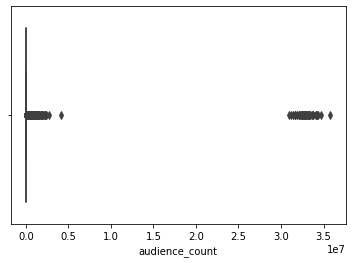

In [37]:
#Side note, I wonder if I could find the most popular actors or studios - I mean there must be bias there, right?
#Then, if I could somehow remove that bias and say, standardize for them then I could find even more hidden gems
#ok! Let's try. 
#Before we begin, since I am measuring popularity, then it would make sense that those would collerate well with very popular movies. 
#So I could also say, filter for most popular movies

#Let's do some visualization over movie popularity

import numpy as np

df = df_movies[['movie_title','tomatometer_rating','audience_rating','audience_count','age']].sort_values(by=['audience_count'], ascending=False)
df = df[~df['audience_count'].isnull()].reset_index().drop(columns=['index'])
sns.boxplot(data=df, x=df['audience_count'])

In [13]:
def minmax(df,col,maxscale):
    return ((df[col] - df[col].min()) / (df[col].max() - df[col].min())) * 100

Note: One idea could be to discount opening year performance

In [38]:
df['audience_count_mod'] = minmax(df,'audience_count',100)

#I want a weight which assigns more weight to more recent movies and negatively adjusts old movies with high audience count 
df['audience_c_age'] = df['audience_count_mod'] / (.500 * df['age']**1.5)
#df[(df.audience_count<2000000) & (df.audience_count>1000000)].reset_index().drop(columns=['index'])
#sns.histplot(df[(df.audience_count<2000000) & (df.audience_count>1000000)])
#sns.histplot(df[df.audience_count>500])

In [39]:
df[(df.audience_c_age > 0.00) & (df.audience_count_mod < 87)].sort_values(by='audience_c_age', ascending=False)[1:100]

,movie_title,tomatometer_rating,audience_rating,audience_count,age,audience_count_mod,audience_c_age
50,Transformers: Revenge of the Fallen,20.00,57.00,4081606.00,14.09,11.40,0.43
53,Shutter Island,68.00,76.00,2374219.00,13.44,6.63,0.27
51,Pirates of the Caribbean: At Worlds End,44.00,72.00,2738491.00,16.18,7.65,0.24
52,Transformers,58.00,85.00,2385106.00,16.07,6.66,0.21
58,Push,23.00,42.00,2026452.00,14.47,5.66,0.21
54,Harry Potter and the Order of the Phoenix,78.00,81.00,2333513.00,16.05,6.52,0.20
55,Spider-Man 3,62.00,51.00,2265043.00,16.24,6.33,0.19
56,Shrek the Third,41.00,52.00,2218576.00,16.20,6.20,0.19
85,The Dark Knight Rises,87.00,90.00,1211961.00,11.02,3.39,0.19
57,Knocked Up,90.00,83.00,2084929.00,16.16,5.82,0.18


In [15]:
df_movies[~df_movies.audience_count.isnull()].audience_count.describe()

count      17415.00
mean      143940.07
std      1763577.42
min            5.00
25%          707.50
50%         4277.00
75%        24988.00
max     35797635.00
Name: audience_count, dtype: float64